In [ ]:
from google.colab import files
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/LeadWalnut/data.csv")

In [ ]:
!pip install sentence-transformers textstat -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.2 MB/s eta 0:00:00


In [ ]:
df.head()
df.columns

Index(['url', 'html_content'], dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if 'html_content' in df.columns:
    print(" PRIMARY DATASET DETECTED!")
    print("   You have pre-scraped HTML content.")
    print(f"\n   Sample HTML length: {len(str(df['html_content'].iloc[0]))} characters")
else:
    print("  ALTERNATIVE DATASET DETECTED!")
    print("   You only have URLs - you'll need to scrape first.")

print(f"\nTotal URLs: {len(df)}")
print(f"Missing values:\n{df.isnull().sum()}")

 PRIMARY DATASET DETECTED!
   You have pre-scraped HTML content.

   Sample HTML length: 142847 characters

Total URLs: 81
Missing values:
url              0
html_content    12
dtype: int64


In [ ]:
# Function to parse HTML and extract title, body text, and word count
def parse_html(html_content):
    """
    Parse HTML content and extract title, body text, and word count
    """
    try:
        # Check if html_content is valid
        if pd.isna(html_content) or html_content == '':
            return None, None, 0

        # Parse HTML
        soup = BeautifulSoup(html_content, 'lxml')

        # Extract title
        title = ''
        if soup.find('title'):
            title = soup.find('title').get_text().strip()
        elif soup.find('h1'):
            title = soup.find('h1').get_text().strip()

        # Extract body text from common content tags
        body_tags = soup.find_all(['p', 'article', 'main', 'div', 'section'])
        body_text = ' '.join([tag.get_text() for tag in body_tags])

        # Clean the text
        body_text = ' '.join(body_text.split())  # Remove extra whitespace
        body_text = body_text.strip()

        # Calculate word count
        word_count = len(body_text.split()) if body_text else 0

        return title, body_text, word_count

    except Exception as e:
        print(f"Error parsing HTML: {str(e)}")
        return None, None, 0

print(" HTML parsing function created!")

 HTML parsing function created!


In [ ]:
# Parse all HTML content
print("Parsing HTML content...")
print("This may take 1-2 minutes...\n")

results = []

for idx, row in df.iterrows():
    url = row['url']
    html_content = row['html_content']

    # Parse HTML
    title, body_text, word_count = parse_html(html_content)

    results.append({
        'url': url,
        'title': title,
        'body_text': body_text,
        'word_count': word_count
    })

    # Progress indicator
    if (idx + 1) % 10 == 0:
        print(f"✓ Processed {idx + 1}/{len(df)} URLs")

# Create DataFrame
df_extracted = pd.DataFrame(results)

print(f"\n Parsing complete!")
print(f"Total pages processed: {len(df_extracted)}")
print(f"Pages with valid content: {(df_extracted['word_count'] > 0).sum()}")
print(f"Pages with no content: {(df_extracted['word_count'] == 0).sum()}")

Parsing HTML content...
This may take 1-2 minutes...

✓ Processed 10/81 URLs
✓ Processed 20/81 URLs
✓ Processed 30/81 URLs
✓ Processed 40/81 URLs
✓ Processed 50/81 URLs
✓ Processed 60/81 URLs
✓ Processed 70/81 URLs
✓ Processed 80/81 URLs

 Parsing complete!
Total pages processed: 81
Pages with valid content: 69
Pages with no content: 12


In [ ]:
# View the extracted data
print("Sample of extracted content:\n")
print(df_extracted.head())

print("\n" + "="*60)
print("Word Count Statistics:")
print("="*60)
print(df_extracted['word_count'].describe())

print("\n" + "="*60)
print("Pages with lowest word counts:")
print("="*60)
print(df_extracted.nsmallest(5, 'word_count')[['url', 'title', 'word_count']])

print("\n" + "="*60)
print(" Pages with highest word counts:")
print("="*60)
print(df_extracted.nsmallest(5, 'word_count')[['url', 'title', 'word_count']])

Sample of extracted content:

                                                 url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   
3  https://www.cisa.gov/topics/cybersecurity-best...   
4  https://www.qnbtrust.bank/Resources/Learning-C...   

                                               title  \
0                                Cyber Security Blog   
1  Top 10 Cybersecurity Awareness Tips: How to St...   
2  11 Cyber Defense Tips to Stay Secure at Work a...   
3  Cybersecurity Best Practices | Cybersecurity a...   
4                                               None   

                                           body_text  word_count  
0  Back Training NCSC Assured Cyber Incident Plan...       47620  
1  Platform The #1 Data Security Platform Varonis...       20613  
2  CIS Portal LoginCIS Hardened Images®SupportCIS...       16090  
3  Skip to main content An o

In [ ]:
# Filter out pages with no content (word_count = 0)
df_extracted_clean = df_extracted[df_extracted['word_count'] > 0].copy()

print(f"Removed {len(df_extracted) - len(df_extracted_clean)} pages with no content")
print(f"Working with {len(df_extracted_clean)} valid pages")

# Reset index
df_extracted_clean.reset_index(drop=True, inplace=True)

Removed 12 pages with no content
Working with 69 valid pages


In [ ]:
# Save to CSV (without html_content to keep file size small)
df_extracted_clean.to_csv('extracted_content.csv', index=False)

print("Extracted content saved to 'extracted_content.csv'")
print(f"File contains {len(df_extracted_clean)} rows")
print(f"Columns: {list(df_extracted_clean.columns)}")

# Preview
df_extracted_clean.head()

Extracted content saved to 'extracted_content.csv'
File contains 69 rows
Columns: ['url', 'title', 'body_text', 'word_count']


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Back Training NCSC Assured Cyber Incident Plan...,47620
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Platform The #1 Data Security Platform Varonis...,20613
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,CIS Portal LoginCIS Hardened Images®SupportCIS...,16090
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Skip to main content An official website of th...,13848
4,https://nordlayer.com/learn/network-security/b...,Network Security 101: Understanding the Basics,PlatformFeaturesPricingResourcesPartnersLog in...,27224


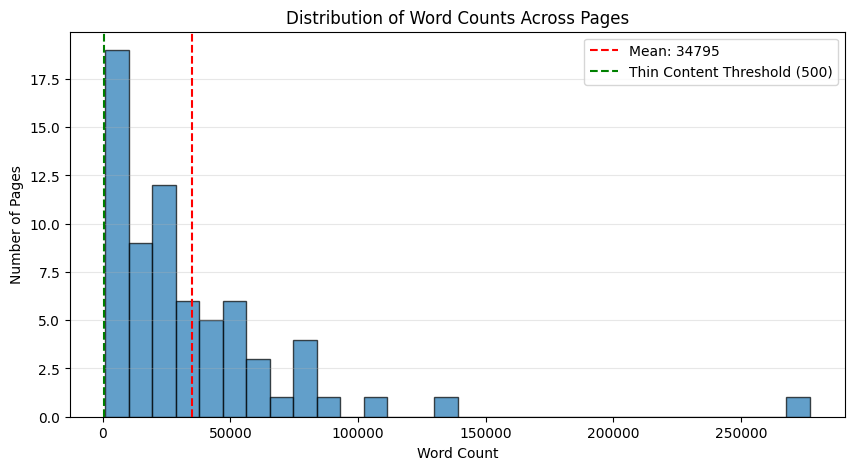


 Pages below 500 words (thin content): 0


In [ ]:
# Visualize word count distribution
plt.figure(figsize=(10, 5))
plt.hist(df_extracted_clean['word_count'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Number of Pages')
plt.title('Distribution of Word Counts Across Pages')
plt.axvline(df_extracted_clean['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_extracted_clean["word_count"].mean():.0f}')
plt.axvline(500, color='green', linestyle='--', label='Thin Content Threshold (500)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"\n Pages below 500 words (thin content): {(df_extracted_clean['word_count'] < 500).sum()}")

Feature Engineering

In [ ]:
#Calculate Senctence count
# Function to count sentences
import re

def count_sentences(text):
    """Count number of sentences in text"""
    if not text or pd.isna(text):
        return 0
    # Split by sentence-ending punctuation
    sentences = re.split(r'[.!?]+', text)
    # Filter out empty strings
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

# Add sentence count to dataframe
df_extracted_clean['sentence_count'] = df_extracted_clean['body_text'].apply(count_sentences)

print(" Sentence count calculated!")
print(f"Average sentences per page: {df_extracted_clean['sentence_count'].mean():.0f}")
df_extracted_clean[['url', 'word_count', 'sentence_count']].head()

 Sentence count calculated!
Average sentences per page: 2448


,url,word_count,sentence_count
0,https://www.cm-alliance.com/cybersecurity-blog,47620,2205
1,https://www.varonis.com/blog/cybersecurity-tips,20613,1180
2,https://www.cisecurity.org/insights/blog/11-cy...,16090,864
3,https://www.cisa.gov/topics/cybersecurity-best...,13848,618
4,https://nordlayer.com/learn/network-security/b...,27224,2045


In [ ]:
#Calculate Readability Score (Flesch Reading Ease)
# Function to calculate readability
def calculate_readability(text):
    """Calculate Flesch Reading Ease score"""
    try:
        if not text or pd.isna(text) or len(text.strip()) < 100:
            return 0
        score = textstat.flesch_reading_ease(text)
        return round(score, 2)
    except:
        return 0

# Add readability score
print("Calculating readability scores...")
df_extracted_clean['flesch_reading_ease'] = df_extracted_clean['body_text'].apply(calculate_readability)

print("Readability scores calculated!")
print(f"\nReadability Statistics:")
print(df_extracted_clean['flesch_reading_ease'].describe())

# Show interpretation
print("\n Flesch Reading Ease Interpretation:")
print("90-100: Very Easy (5th grade)")
print("60-70:  Standard (8th-9th grade)")
print("30-50:  Difficult (College)")
print("0-30:   Very Difficult (College graduate)")

df_extracted_clean[['url', 'word_count', 'flesch_reading_ease']].head()

Calculating readability scores...
Readability scores calculated!

Readability Statistics:
count     69.000000
mean      30.171159
std       24.254965
min      -27.750000
25%       10.040000
50%       31.000000
75%       43.960000
max      103.410000
Name: flesch_reading_ease, dtype: float64

 Flesch Reading Ease Interpretation:
90-100: Very Easy (5th grade)
60-70:  Standard (8th-9th grade)
30-50:  Difficult (College)
0-30:   Very Difficult (College graduate)


,url,word_count,flesch_reading_ease
0,https://www.cm-alliance.com/cybersecurity-blog,47620,30.43
1,https://www.varonis.com/blog/cybersecurity-tips,20613,31.00
2,https://www.cisecurity.org/insights/blog/11-cy...,16090,22.33
3,https://www.cisa.gov/topics/cybersecurity-best...,13848,-0.98
4,https://nordlayer.com/learn/network-security/b...,27224,4.26


In [ ]:
#Extract Top 5 Keywords Using TF-IDF
# Extract keywords using TF-IDF
print(" Extracting keywords using TF-IDF...")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,  # Consider top 100 words
    stop_words='english',
    ngram_range=(1, 2),  # Include single words and bigrams
    min_df=2  # Word must appear in at least 2 documents
)

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(df_extracted_clean['body_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Extract top 5 keywords for each document
def get_top_keywords(doc_index, top_n=5):
    """Get top N keywords for a document"""
    # Get TF-IDF scores for this document
    tfidf_scores = tfidf_matrix[doc_index].toarray()[0]
    # Get top N indices
    top_indices = tfidf_scores.argsort()[-top_n:][::-1]
    # Get corresponding keywords
    keywords = [feature_names[i] for i in top_indices if tfidf_scores[i] > 0]
    return '|'.join(keywords) if keywords else ''

# Apply to all documents
df_extracted_clean['top_keywords'] = [get_top_keywords(i) for i in range(len(df_extracted_clean))]

print("Keywords extracted!")
print("\n Sample keywords:")
for i in range(min(3, len(df_extracted_clean))):
    print(f"\nURL: {df_extracted_clean.iloc[i]['url'][:50]}...")
    print(f"Keywords: {df_extracted_clean.iloc[i]['top_keywords']}")

 Extracting keywords using TF-IDF...
Keywords extracted!

 Sample keywords:

URL: https://www.cm-alliance.com/cybersecurity-blog...
Keywords: cyber|2025|cybersecurity|october|security

URL: https://www.varonis.com/blog/cybersecurity-tips...
Keywords: data|security|cloud|access|ai

URL: https://www.cisecurity.org/insights/blog/11-cyber-...
Keywords: cybersecurity|secure|security|cyber|use


In [ ]:
# Generate embeddings using sentence transformers
print("🔄 Generating embeddings using Sentence Transformers...")
print("This will take 2-3 minutes...")

# Load model (this is lightweight and fast)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for all documents
# Truncate text to avoid memory issues (use first 5000 characters)
texts_for_embedding = df_extracted_clean['body_text'].apply(lambda x: x[:5000] if x else '')
embeddings = embedding_model.encode(texts_for_embedding.tolist(), show_progress_bar=True)

print(f"\n✅ Embeddings generated!")
print(f"Embedding shape: {embeddings.shape}")
print(f"Each document is represented by a {embeddings.shape[1]}-dimensional vector")

# Store embeddings as a list of lists (for CSV compatibility)
df_extracted_clean['embedding'] = [emb.tolist() for emb in embeddings]

🔄 Generating embeddings using Sentence Transformers...
This will take 2-3 minutes...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Embeddings generated!
Embedding shape: (69, 384)
Each document is represented by a 384-dimensional vector


In [ ]:
# Display feature summary
print("="*70)
print(" FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"\n Total documents: {len(df_extracted_clean)}")
print(f"\nFeatures extracted:")
print(f"   • Word Count: {df_extracted_clean['word_count'].min()} - {df_extracted_clean['word_count'].max()}")
print(f"   • Sentence Count: {df_extracted_clean['sentence_count'].min()} - {df_extracted_clean['sentence_count'].max()}")
print(f"   • Readability: {df_extracted_clean['flesch_reading_ease'].min():.1f} - {df_extracted_clean['flesch_reading_ease'].max():.1f}")
print(f"   • Keywords: Top 5 per document")
print(f"   • Embeddings: {embeddings.shape[1]}-dimensional vectors")

# Show sample
print("\n" + "="*70)
print(" Sample Feature Vector:")
print("="*70)
df_extracted_clean[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords']].head(3)

 FEATURE ENGINEERING SUMMARY

 Total documents: 69

Features extracted:
   • Word Count: 1017 - 276942
   • Sentence Count: 45 - 32896
   • Readability: -27.8 - 103.4
   • Keywords: Top 5 per document
   • Embeddings: 384-dimensional vectors

 Sample Feature Vector:


,url,word_count,sentence_count,flesch_reading_ease,top_keywords
0,https://www.cm-alliance.com/cybersecurity-blog,47620,2205,30.43,cyber|2025|cybersecurity|october|security
1,https://www.varonis.com/blog/cybersecurity-tips,20613,1180,31.00,data|security|cloud|access|ai
2,https://www.cisecurity.org/insights/blog/11-cy...,16090,864,22.33,cybersecurity|secure|security|cyber|use


In [ ]:
#Save Features to CSV
# Prepare features CSV (without body_text to reduce size)
df_features = df_extracted_clean[[
    'url',
    'title',
    'word_count',
    'sentence_count',
    'flesch_reading_ease',
    'top_keywords',
    'embedding'
]].copy()

# Save to CSV
df_features.to_csv('features.csv', index=False)

print(" Features saved to 'features.csv'")
print(f" File contains {len(df_features)} rows")
print(f" Columns: {list(df_features.columns)}")

# Also save a version without embeddings for easier viewing
df_features_simple = df_features.drop('embedding', axis=1)
df_features_simple.to_csv('features_simple.csv', index=False)
print(" Also saved 'features_simple.csv' (without embeddings for easier viewing)")

df_features.head()

 Features saved to 'features.csv'
 File contains 69 rows
 Columns: ['url', 'title', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords', 'embedding']
 Also saved 'features_simple.csv' (without embeddings for easier viewing)


,url,title,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,47620,2205,30.43,cyber|2025|cybersecurity|october|security,"[-0.05029544234275818, -0.02475261129438877, -..."
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,20613,1180,31.00,data|security|cloud|access|ai,"[-0.036791760474443436, -0.0452534481883049, -..."
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,16090,864,22.33,cybersecurity|secure|security|cyber|use,"[-0.03238895907998085, -0.04882122576236725, -..."
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,13848,618,-0.98,cybersecurity|cyber|secure|best|security,"[-0.004203029442578554, -0.07358797639608383, ..."
4,https://nordlayer.com/learn/network-security/b...,Network Security 101: Understanding the Basics,27224,2045,4.26,network|security|access|networks|secure,"[-0.08516757190227509, 0.04618396610021591, -0..."


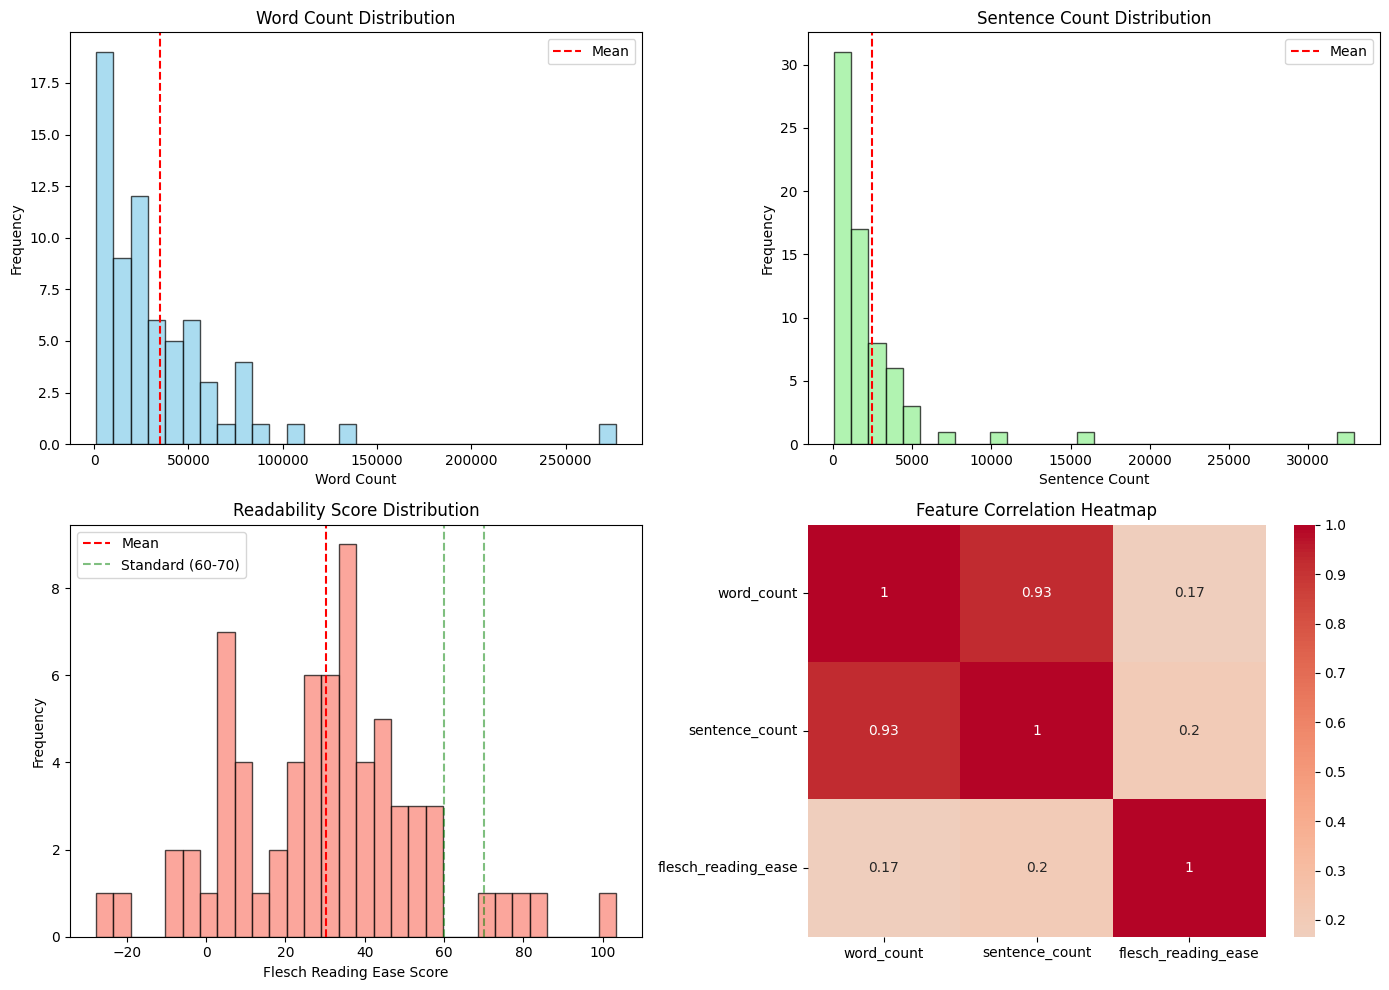

Visualizations complete!


In [ ]:
#Visalize the Feature Distribution
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Word Count Distribution
axes[0, 0].hist(df_extracted_clean['word_count'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Word Count Distribution')
axes[0, 0].axvline(df_extracted_clean['word_count'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# 2. Sentence Count Distribution
axes[0, 1].hist(df_extracted_clean['sentence_count'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Sentence Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Sentence Count Distribution')
axes[0, 1].axvline(df_extracted_clean['sentence_count'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# 3. Readability Score Distribution
axes[1, 0].hist(df_extracted_clean['flesch_reading_ease'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
axes[1, 0].set_xlabel('Flesch Reading Ease Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Readability Score Distribution')
axes[1, 0].axvline(df_extracted_clean['flesch_reading_ease'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].axvline(60, color='green', linestyle='--', label='Standard (60-70)', alpha=0.5)
axes[1, 0].axvline(70, color='green', linestyle='--', alpha=0.5)
axes[1, 0].legend()

# 4. Feature Correlation
correlation_data = df_extracted_clean[['word_count', 'sentence_count', 'flesch_reading_ease']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

print("Visualizations complete!")

Duplicate Detection

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load your processed data
df_features = pd.read_csv('features.csv')

# Convert embedding column back to numpy array
df_features['embedding'] = df_features['embedding'].apply(lambda x: np.array(eval(x)))

embeddings = np.vstack(df_features['embedding'].values)
print("Embeddings loaded successfully!")
print(f"Shape: {embeddings.shape}")


Embeddings loaded successfully!
Shape: (69, 384)


In [ ]:
# Compute cosine similarity matrix
print(" Calculating cosine similarity between all documents...")
similarity_matrix = cosine_similarity(embeddings)

# Define threshold for duplicates
threshold = 0.8

duplicate_pairs = []
for i in range(len(df_features)):
    for j in range(i + 1, len(df_features)):
        sim = similarity_matrix[i, j]
        if sim >= threshold:
            duplicate_pairs.append({
                'url_1': df_features.iloc[i]['url'],
                'url_2': df_features.iloc[j]['url'],
                'similarity': round(sim, 3)
            })

df_duplicates = pd.DataFrame(duplicate_pairs)
df_duplicates.to_csv('duplicates.csv', index=False)
print(f" Duplicates detected: {len(df_duplicates)} pairs found (threshold={threshold})")
df_duplicates.head()


 Calculating cosine similarity between all documents...
 Duplicates detected: 70 pairs found (threshold=0.8)


,url_1,url_2,similarity
0,https://www.fortinet.com/resources/cyberglossa...,https://www.fortinet.com/resources/cyberglossa...,1.00
1,https://www.fortinet.com/resources/cyberglossa...,https://www.fortinet.com/solutions/enterprise-...,1.00
2,https://www.phriendlyphishing.com/blog,https://inspiredelearning.com/blog/phishing-pr...,0.81
3,https://en.wikipedia.org/wiki/SD-WAN,https://en.wikipedia.org/wiki/Remote_desktop_s...,1.00
4,https://en.wikipedia.org/wiki/SD-WAN,https://en.wikipedia.org/wiki/Search_engine_op...,1.00


In [ ]:
# Add is_thin column to main dataset (word_count < 500)
df_features['is_thin'] = df_features['word_count'] < 500
df_features.to_csv('features_with_thin_flag.csv', index=False)

print(" 'is_thin' column added and saved to 'features_with_thin_flag.csv'")
print(df_features[['url', 'word_count', 'is_thin']].head())


 'is_thin' column added and saved to 'features_with_thin_flag.csv'
                                                 url  word_count  is_thin
0     https://www.cm-alliance.com/cybersecurity-blog       47620    False
1    https://www.varonis.com/blog/cybersecurity-tips       20613    False
2  https://www.cisecurity.org/insights/blog/11-cy...       16090    False
3  https://www.cisa.gov/topics/cybersecurity-best...       13848    False
4  https://nordlayer.com/learn/network-security/b...       27224    False


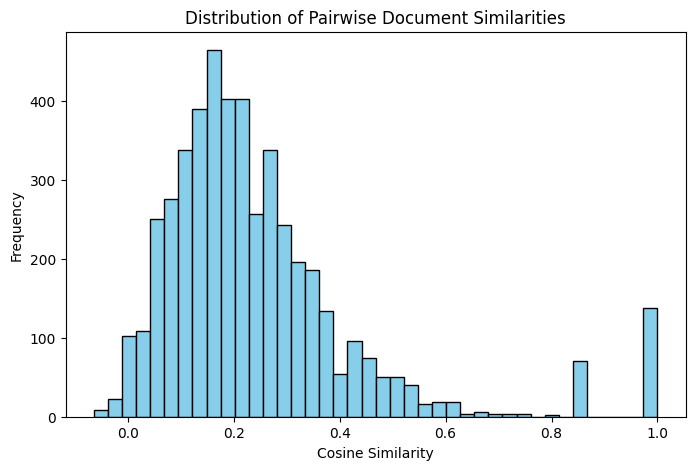

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(similarity_matrix.flatten(), bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Document Similarities")
plt.show()


Content Quality Scoring

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [ ]:
# Load features with 'is_thin'
df = pd.read_csv("features_with_thin_flag.csv")

print(" Features loaded!")
print(df.columns)
df.head(3)


 Features loaded!
Index(['url', 'title', 'word_count', 'sentence_count', 'flesch_reading_ease',
       'top_keywords', 'embedding', 'is_thin'],
      dtype='object')


,url,title,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding,is_thin
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,47620,2205,30.43,cyber|2025|cybersecurity|october|security,[-5.02954423e-02 -2.47526113e-02 -1.12951836e-...,False
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,20613,1180,31.00,data|security|cloud|access|ai,[-3.67917605e-02 -4.52534482e-02 -3.54604386e-...,False
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,16090,864,22.33,cybersecurity|secure|security|cyber|use,[-3.23889591e-02 -4.88212258e-02 -9.17455703e-...,False


In [ ]:
#Create Synethic Labels
def assign_quality_label(row):
    wc = row["word_count"]
    readability = row["flesch_reading_ease"]

    if wc > 1500 and 50 <= readability <= 70:
        return "High"
    elif wc < 500 or readability < 30:
        return "Low"
    else:
        return "Medium"

df["quality_label"] = df.apply(assign_quality_label, axis=1)
print(" Synthetic quality labels created!")
print(df["quality_label"].value_counts())


 Synthetic quality labels created!
quality_label
Low       33
Medium    30
High       6
Name: count, dtype: int64


In [ ]:
#Prepare Feature Matrix and Target
X = df[["word_count", "sentence_count", "flesch_reading_ease"]]
y = df["quality_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (55, 3), Test set: (14, 3)


In [ ]:
#Train Models (Random Forest + Baseline)
# Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Baseline: simple rule-based (uses same conditions)
def baseline_rule(row):
    wc = row["word_count"]
    r = row["flesch_reading_ease"]
    if wc > 1500 and 50 <= r <= 70:
        return "High"
    elif wc < 500 or r < 30:
        return "Low"
    else:
        return "Medium"

y_pred_baseline = X_test.copy()
y_pred_baseline["pred"] = X_test.apply(baseline_rule, axis=1)


In [ ]:
#Evaluate Both Models
print("="*60)
print(" Random Forest Model Performance")
print("="*60)
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("F1-Score (macro):", round(f1_score(y_test, y_pred_rf, average="macro"), 3))

print("\n" + "="*60)
print(" Baseline Rule Performance")
print("="*60)
print(classification_report(y_test, y_pred_baseline["pred"]))
print("Accuracy:", round(accuracy_score(y_test, y_pred_baseline["pred"]), 3))
print("F1-Score (macro):", round(f1_score(y_test, y_pred_baseline["pred"], average="macro"), 3))


 Random Forest Model Performance
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
         Low       1.00      1.00      1.00         7
      Medium       1.00      1.00      1.00         6

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Accuracy: 1.0
F1-Score (macro): 1.0

 Baseline Rule Performance
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
         Low       1.00      1.00      1.00         7
      Medium       1.00      1.00      1.00         6

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Accuracy: 1.0
F1-Score (macro): 1.0


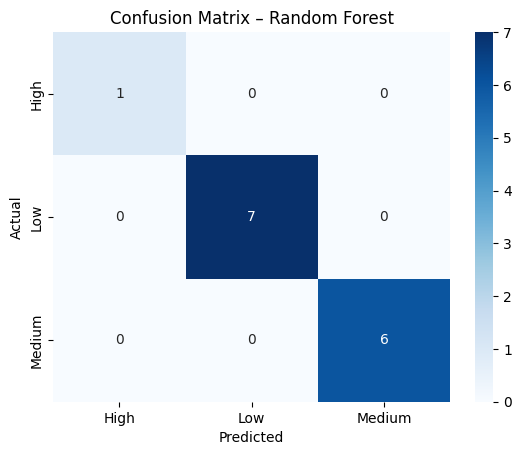

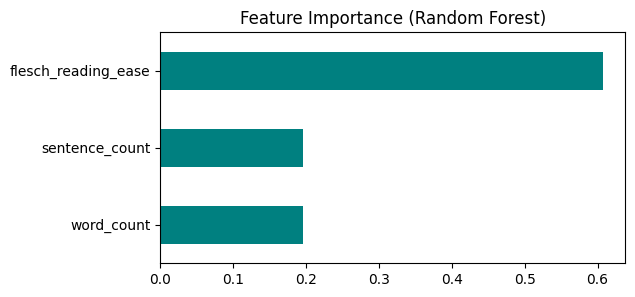

In [ ]:
#Visualize Confusion Matrix and Feature Importance
cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
sns.heatmap(pd.DataFrame(cm, index=rf.classes_, columns=rf.classes_),
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.plot(kind='barh', color='teal', figsize=(6,3))
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
import os

# Create the folder if it doesn’t exist
os.makedirs("models", exist_ok=True)

# Now save the model
import joblib
joblib.dump(rf, "models/quality_model.pkl")
print("✅ Model saved successfully at 'models/quality_model.pkl'")



✅ Model saved successfully at 'models/quality_model.pkl'


Real-Time URL Analysis Function

In [ ]:
# --- Imports ---
import os, re, json, ast
import numpy as np, pandas as pd, joblib, requests, textstat
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# --- Load trained Random Forest model ---
rf_model = joblib.load("models/quality_model.pkl")

# --- Load sentence-transformer model for embeddings ---
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Load feature dataset (for duplicate check) ---
df_features = pd.read_csv("features_with_thin_flag.csv")

# --- Safe embedding parser (handles missing commas) ---
def safe_parse_embedding(x):
    try:
        if isinstance(x, (list, np.ndarray)):
            return np.array(x)
        s = str(x).strip()
        if s.startswith('[') and ',' in s:
            return np.array(json.loads(s))
        s_fixed = re.sub(r'(?<=\d)\s+(?=-?\d)', ', ', s)
        return np.array(ast.literal_eval(s_fixed))
    except Exception:
        return np.zeros(384)     # fallback if corrupted

df_features["embedding"] = df_features["embedding"].apply(safe_parse_embedding)
stored_embeddings = np.vstack(df_features["embedding"].values)

print(" Model and embeddings loaded successfully!")
print("Stored embeddings shape:", stored_embeddings.shape)


 Model and embeddings loaded successfully!
Stored embeddings shape: (69, 384)


In [ ]:
#Define the Real-Time Analyzer Function
def analyze_url(url, duplicate_threshold=0.8):
    """
    Analyze a web page: scrape content, extract features,
    predict quality label, and detect near-duplicates.
    Returns a JSON-like dict.
    """
    try:
        # ---------- 1. Fetch ----------
        headers = {"User-Agent": "Mozilla/5.0"}
        resp = requests.get(url, headers=headers, timeout=15)
        if resp.status_code != 200:
            return {"error": f"Failed to fetch URL (status {resp.status_code})"}

        # ---------- 2. Parse ----------
        soup = BeautifulSoup(resp.text, "lxml")
        title = soup.title.string.strip() if soup.title else ""
        body = " ".join(p.get_text(" ", strip=True) for p in soup.find_all("p"))
        body = re.sub(r"\s+", " ", body)
        if len(body) < 100:
            return {"error": "Insufficient textual content for analysis."}

        # ---------- 3. Compute features ----------
        word_count = len(body.split())
        sentence_count = len(re.split(r"[.!?]+", body))
        readability = textstat.flesch_reading_ease(body)

        # ---------- 4. Predict quality ----------
        X_new = pd.DataFrame([[word_count, sentence_count, readability]],
                             columns=["word_count", "sentence_count", "flesch_reading_ease"])
        quality_label = rf_model.predict(X_new)[0]

        # ---------- 5. Embedding + duplicate detection ----------
        new_emb = embedding_model.encode([body[:5000]])   # limit long text
        sims = cosine_similarity(new_emb, stored_embeddings)[0]
        top_idx = np.argmax(sims)
        top_sim = float(sims[top_idx])
        duplicate_info = {}
        if top_sim >= duplicate_threshold:
            duplicate_info = {
                "url": df_features.iloc[top_idx]["url"],
                "similarity": round(top_sim, 3)
            }

        # ---------- 6. Build structured output ----------
        result = {
            "url": url,
            "title": title,
            "word_count": int(word_count),
            "sentence_count": int(sentence_count),
            "flesch_reading_ease": round(readability, 2),
            "quality_label": quality_label,
            "is_thin": word_count < 500,
            "duplicate_detected": bool(top_sim >= duplicate_threshold),
            "similar_to": duplicate_info
        }
        return result

    except Exception as e:
        return {"error": str(e)}


In [ ]:
#Test the Function on a Live URL
test_url = "https://www.cisa.gov/topics/cybersecurity-best-practices"

result = analyze_url(test_url)
print(json.dumps(result, indent=2))


{
  "url": "https://www.cisa.gov/topics/cybersecurity-best-practices",
  "title": "Cybersecurity Best Practices | Cybersecurity and Infrastructure Security Agency CISA",
  "word_count": 612,
  "sentence_count": 34,
  "flesch_reading_ease": 15.8,
  "quality_label": "Low",
  "is_thin": false,
  "duplicate_detected": false,
  "similar_to": {}
}


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from textstat import flesch_reading_ease
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# ---------------------------
# Load trained model
# ---------------------------
model = joblib.load("models/quality_model.pkl")

# ---------------------------
# Helper: extract content from URL
# ---------------------------
def extract_content(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        r = requests.get(url, headers=headers, timeout=10)
        if r.status_code != 200:
            return None
        soup = BeautifulSoup(r.text, "html.parser")
        title = soup.title.string if soup.title else "No Title"
        body = " ".join([p.get_text() for p in soup.find_all("p")])
        return {"title": title, "body": body}
    except Exception as e:
        return None

# ---------------------------
# Helper: extract features
# ---------------------------
def extract_features(text):
    text = text.lower().strip()
    word_count = len(text.split())
    sentence_count = text.count(".") + text.count("!") + text.count("?")
    readability = flesch_reading_ease(text)

    vectorizer = TfidfVectorizer(max_features=5, stop_words="english")
    vectorizer.fit([text])
    keywords = vectorizer.get_feature_names_out()

    return {
        "word_count": word_count,
        "sentence_count": sentence_count,
        "flesch_reading_ease": readability,
        "top_keywords": list(keywords)
    }

# ---------------------------
# Streamlit UI
# ---------------------------
st.set_page_config(page_title="SEO Content Quality & Duplicate Detector", layout="centered")

st.title(" SEO Content Quality & Duplicate Detector")
st.write("Analyze webpage SEO content quality and detect duplicates using ML model.")

url = st.text_input("Enter a webpage URL:")

if st.button("Analyze"):
    with st.spinner("Fetching and analyzing content..."):
        content = extract_content(url)
        if not content:
            st.error("Failed to fetch or parse content. Please check the URL.")
        else:
            features = extract_features(content["body"])
            X = np.array([[features["word_count"], features["sentence_count"], features["flesch_reading_ease"]]])
            prediction = model.predict(X)[0]

            st.subheader(f"Quality Prediction: **{prediction}**")
            st.write(f"**Title:** {content['title']}")
            st.write(f"**Word Count:** {features['word_count']}")
            st.write(f"**Readability Score:** {features['flesch_reading_ease']:.2f}")
            st.write(f"**Top Keywords:** {', '.join(features['top_keywords'])}")


ModuleNotFoundError: No module named 'streamlit'